/tmp/ipykernel_1947649/2006580804.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


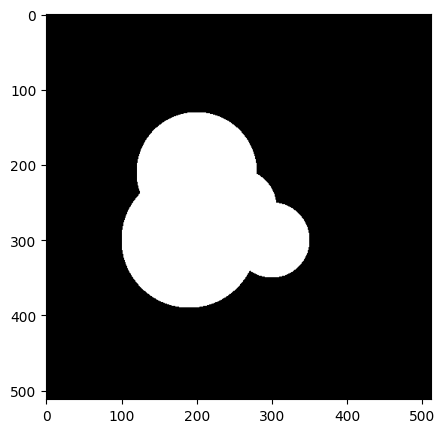

In [1]:
import SimpleITK as sitk
import numpy as np

import matplotlib.pyplot as plt

# create an empty array
arr = np.zeros((512,512), dtype=bool)
xx,yy = np.indices(arr.shape)


# add a bunch of overlapping circles
cond = (xx-256)**2 + (yy-256)**2 < 50**2
arr[cond] = 1

cond = (xx-300)**2 + (yy-300)**2 < 50**2
arr[cond] = 1

cond = (xx-210)**2 + (yy-200)**2 < 80**2
arr[cond] = 1

cond = (xx-300)**2 + (yy-190)**2 < 90**2
arr[cond] = 1

# display
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(arr, interpolation=None, cmap=plt.cm.Greys_r)
fig.show()

In [6]:
import glob
from datetime import datetime
from itertools import groupby
from pathlib import Path
import numpy as np
import pims
from scipy.io import savemat
from skimage.io import imsave
import numbers
import zarr

def import_dataset_FullEmbryo(name_folder, trim_series):
    """
    Imports and collates the data files in the name_directory, and generates
    metadata dictionaries for the origininal files metadata and new metadata
    corresponding to the collated file.

    :param str name_folder: Path to name folder containing data files.
    :param bool trim_series: If True, deletes the last frame of each series.
        This should be used when acquisition was stopped in the middle of a
        z-stack.
    :return: Tuple(channels_full_dataset, original_global_metadata,
           original_frame_metadata, export_global_metadata,
           export_frame_metadata)
           * ``channels_full_dataset``: list of numpy arrays, with each
           element of the list being a collated dataset for a given channel.
           * ``original_global_metadata``: dictionary of global metadata
           for all files and series in a dataset.
           * ``original_frame_metadata``: dictionary of frame-by-frame metadata
           for all files and series in a dataset.
           * ``export_global_metadata``: list of dictionaries of global
           metadata for the collated dataset, with each element of the list
           corresponding to a channel.
           * ``export_frame_metadata``: list of dictionaries of frame-by-frame
           metadata for the collated dataset, with each element of the list
           corresponding to a channel.
    :rtype: Tuple of dicts
    """
    file_path = "".join([name_folder, "/FullEmbryo/", "*.lif"])
    file_list = glob.glob(file_path)
    file_list.sort()

    # Metadata fields to ignore during consistency checks (these fields
    # typically vary from series to series).
    ignore_fields = [
        "ChannelID",
        "FilterID",
        "ImageAcquisitionDate",
        "ImageID",
        "ImageInstrumentRef",
        "ImageName",
        "InstrumentID",
        "LightPathEmissionFilterRef",
        "ObjectiveID",
        "ObjectiveSettingsID",
        "PixelsID",
        "PixelsSizeT",
        "PlaneCount",
    ]

    # We pull the individual data files into a list as pipeline objects.
    # Pulling the frame-by-frame metadata is deferred until the collation step
    # since it forces a (slower) read from disk.
    data = []  # One element per series
    num_frames_series = []  # One element per series
    metadata_list = []  # One element per file

    for file in file_list:
        # Open a reader for the first series of the file
        if 'Mid' in file:
            
        series = pims.Bioformats(file, series=0)
        try:
            series.bundle_axes = "tczyx"
            multichannel = True
        except ValueError:
            series.bundle_axes = "tzyx"
            multichannel = False

        data.append(series)
        num_frames_series.append((series.shape)[1])

        # Extract metadata for each file and do consistency checks
        file_metadata = extract_global_metadata(series.metadata)
        checked_file_metadata = check_metadata(file_metadata, ignore_fields)
        metadata_list.append(checked_file_metadata)

        # Open subsequent readers for each series within the file
        num_series = checked_file_metadata["ImageCount"]
        for i in range(1, num_series):
            series = pims.Bioformats(file, series=i)
            if multichannel:
                series.bundle_axes = "tczyx"
            else:
                series.bundle_axes = "tzyx"
            data.append(series)
            num_frames_series.append((series.shape)[1])

    # We check for imaging settings consistency between files (the previous
    # block should already have checked for consistency between series).
    full_dataset_global_metadata = {}
    for file_metadata in metadata_list:
        for field in file_metadata:
            if field in full_dataset_global_metadata:
                full_dataset_global_metadata[field].append(file_metadata[field])
            else:
                full_dataset_global_metadata[field] = [file_metadata[field]]

    original_global_metadata = check_metadata(
        full_dataset_global_metadata, ignore_fields
    )

    num_frames_series = np.array(num_frames_series)  # Numpy array more
    # convenient for later
    # slicing

    num_frames = np.sum(num_frames_series)
    num_series = num_frames_series.size
    if trim_series:
        num_frames = num_frames - num_series
        num_frames_series = num_frames_series - 1
        end = -1
    else:
        end = None

    series_shape = data[0].shape
    dataset_shape = (
        num_frames,
        *series_shape[2:],
    )

    dtype = original_global_metadata["PixelsType"]
    full_dataset = np.empty(dataset_shape, dtype=dtype)

    original_frame_metadata = {}  # One element per series

    # Collate the dataset and pull frame-by-frame metadata
    series_start = 0
    for i, _ in enumerate(data):
        series_end = series_start + num_frames_series[i]
        full_dataset[series_start:series_end] = data[i][0][:end]
        series_frame_metadata = data[i][0].metadata

        for frame_key in series_frame_metadata:
            if frame_key in original_frame_metadata:
                original_frame_metadata[frame_key].append(
                    series_frame_metadata[frame_key]
                )
            else:
                original_frame_metadata[frame_key] = [series_frame_metadata[frame_key]]

        series_start = series_end

    # Create metadata dicts for the collated data
    export_global_metadata, export_frame_metadata = collate_metadata(
        original_global_metadata, original_frame_metadata, trim_series
    )

    # Close the readers
    for reader in data:
        reader.close()

    # Split datasets into channels
    num_channels = original_global_metadata["ChannelCount"]
    channels_full_dataset = []
    for i in range(num_channels):
        if num_channels > 1:
            channels_full_dataset.append(full_dataset[:, i, ...])
        else:
            channels_full_dataset.append(full_dataset)

    return (
        channels_full_dataset,
        original_global_metadata,
        original_frame_metadata,
        export_global_metadata,
        export_frame_metadata,
    )

ModuleNotFoundError: No module named 'ImageReader'

In [2]:
# create a SimpleITK image
img = sitk.GetImageFromArray(arr.astype(int))

# generate label 
filter_label = sitk.LabelShapeStatisticsImageFilter()
filter_label.SetComputeFeretDiameter(True)
filter_label.Execute(img)

# compute the Feret diameter
# the 1 means we are computing for the label with value 1
filter_label.GetFeretDiameter(1)

264.25177388240934

In [3]:
# we have to get a bit smarter for the principal moments
pc1_x, pc1_y, pc2_x, pc2_y = filter_label.GetPrincipalAxes(1)

# get the center of mass
com_y, com_x = filter_label.GetCentroid(1)

# now trace the distance from the centroid to the edge along the principal axes
# we use some linear algebra

# get the position of each point in the image
v_x, v_y = np.where(arr)

# convert these positions to a vector from the centroid
v_pts = np.array((v_x - com_x, v_y - com_y)).T

# project along the first principal component
distances_pc1 = np.dot(v_pts, np.array((pc1_x, pc1_y)))

# get the extent
dmax_1 = distances_pc1.max()
dmin_1 = distances_pc1.min()

# project along the second principal component
distances_pc2 = np.dot(v_pts, np.array((pc2_x, pc2_y)))

# get the extent
dmax_2 = distances_pc2.max()
dmin_2 = distances_pc2.min()

# the total diameter is the difference in these distances
print("Distance along major axis:", dmax_1 - dmin_1)
print("Distance along minor axis:", dmax_2 - dmin_2)

Distance along major axis: 258.5497770889507
Distance along minor axis: 251.97123773093475


/tmp/ipykernel_1947649/2775340065.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


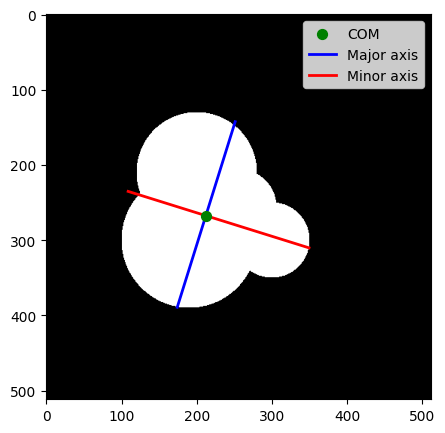

In [4]:
# display
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(arr, interpolation=None, cmap=plt.cm.Greys_r)

ax.scatter(com_y, com_x, c="g", marker="o", s=50, zorder=99, label="COM")

ax.plot((com_y, com_y+dmax_1*pc1_y), (com_x, com_x+dmax_1*pc1_x), lw=2, c='b')
ax.plot((com_y, com_y+dmin_1*pc1_y), (com_x, com_x+dmin_1*pc1_x), lw=2, c='b', label="Major axis")

ax.plot((com_y, com_y+dmax_2*pc2_y), (com_x, com_x+dmax_2*pc2_x), lw=2, c='r')
ax.plot((com_y, com_y+dmin_2*pc2_y), (com_x, com_x+dmin_2*pc2_x), lw=2, c='r', label="Minor axis")

ax.legend()

fig.show()